# Load Library and Custom Functions

In [1]:
# this is training for job families actually

In [2]:
# Base
import pandas as pd
import numpy as np
import random as rnd
from math import floor
import sys, os, re, csv, codecs
import time
import datetime
import pickle

# import web base
from flask import Flask

# import nlp
import spacy

# import sklearn
from sklearn.model_selection import train_test_split

# Tensorflow 2.0 import Keras for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Activation,Flatten,Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D,GlobalAveragePooling1D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# visualization
import pydot
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
%matplotlib inline

# ProgressBar
from tqdm import tqdm

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


In [3]:
# Read Data
df = pd.read_excel(r"/Users/john.kuang/OneDrive - Sequoia/Python/Family/Mercer.xlsx")

In [4]:
df.head(3)

,Family,Subfamily,Title,General Management,Finance,Human Resources,Communications & Corporate Affairs,"Legal, Compliance & Audit","Administration, Facilities & Secretarial",Project/Program Management,...,Production & Skilled Trades,"IT, Telecom & Internet","Data Analytics/Warehousing, & Business Intelligence",Consumer & Commercial Banking,Insurance,Hospitality (Food Service & Lodging),Creative & Design,"Real Estate Management, Property Development & Investment",Construction,Healthcare/Pharmacy Services
0,General Management,General Management,Chairman of the Board (Non CEO) - Global Paren...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,General Management,General Management,Chairman of the Board (Non CEO) - Global Subsi...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,General Management,General Management,Chairman of the Board (Non CEO) - Regional Par...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df=df.sample(frac=1)

In [6]:
df.head(1)

,Family,Subfamily,Title,General Management,Finance,Human Resources,Communications & Corporate Affairs,"Legal, Compliance & Audit","Administration, Facilities & Secretarial",Project/Program Management,...,Production & Skilled Trades,"IT, Telecom & Internet","Data Analytics/Warehousing, & Business Intelligence",Consumer & Commercial Banking,Insurance,Hospitality (Food Service & Lodging),Creative & Design,"Real Estate Management, Property Development & Investment",Construction,Healthcare/Pharmacy Services
3712,"Sales, Marketing & Product Management",Field Sales & Account Management,General Field Sales: Key Clients - Senior Mana...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

In [7]:
# df.Title = df.Title .str.replace('\n', ' ')
df.Title = df.Title .apply(lambda x: x.lower())
df.Title = df.Title .str.replace(r'[^\w\s]+', '')
df.Title = df.Title.str.replace('\d+', '')

In [8]:
ylist=list(df.columns)
ylist.remove("Family")
ylist.remove("Subfamily")
ylist.remove("Title")
# ylist.remove("Level")

In [9]:
print("Total number of job families are:",len(ylist),'\n')
print(ylist)

with open('ylist.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(ylist, filehandle)

Total number of job families are: 22 

['General Management', 'Finance', 'Human Resources', 'Communications & Corporate Affairs', 'Legal, Compliance & Audit', 'Administration, Facilities & Secretarial', 'Project/Program Management', 'Sales, Marketing & Product Management', 'Customer Service & Contact Center Operations', 'Quality Management', 'Supply Chain', 'Engineering & Science', 'Production & Skilled Trades', 'IT, Telecom & Internet', 'Data Analytics/Warehousing, & Business Intelligence', 'Consumer & Commercial Banking', 'Insurance', 'Hospitality (Food Service & Lodging)', 'Creative & Design', 'Real Estate Management, Property Development & Investment', 'Construction', 'Healthcare/Pharmacy Services']


In [10]:
X=df

In [11]:
y=df[ylist]

In [12]:
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=46)

In [13]:
y = X_train[ylist].values
list_sentences_train = X_train["Title"]
list_sentences_test = X_test["Title"]

In [14]:
y.shape[1]

22

In [15]:
nlp = spacy.load('en_core_web_lg')
max_features = 2000
embed_size = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

embeddings_index = np.zeros((max_features, embed_size))
for word, idx in tokenizer.word_index.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# saving the tokenizer for production
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

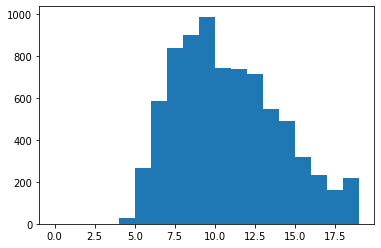

Average number of words is 10.833374597672691


In [16]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,20,1))
plt.show()
print("Average number of words is",np.average(totalNumWords))

# Set Max Length of Input
- This is very important, you want to match your training distribution to actual production input

In [17]:
maxlen = 4

In [18]:
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
# of these job titles take the maxlen number of words based off of human judgment

In [19]:
# timenow = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
# print(timenow)

In [20]:
# tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
# # keep records of how differnt parameters perform

# Training

In [21]:
# input_size=maxlen # this is the number of words in each title
# output_size=y.shape[1] # this is number of job families

# inp = Input(shape=(input_size, ))
# embed_size = 128
# x = Embedding(max_features, embed_size)(inp)
# x = LSTM(32, return_sequences=True,name='lstm_layer')(x)
# x = GlobalAveragePooling1D(data_format='channels_first')(x)
# x = Dropout(0.2)(x)
# x = Dense(output_size, activation="softmax")(x)
# model = Model(inputs=inp, outputs=x)
# model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

input_size=maxlen # this is the number of words in each title
output_size=y.shape[1] # this is number of job families

inp = Input(shape=(input_size, ))
x = Embedding(input_dim=max_features, output_dim=embed_size,weights=[embeddings_index], trainable=False)(inp)
x = SpatialDropout1D(rate=0.1)(x)
x = Bidirectional(LSTM(32, return_sequences=True, stateful=False,name='lstm_layer'))(x)
x = Bidirectional(LSTM(32, return_sequences=False, stateful=False,name='lstm_layer'))(x)
# x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dropout(rate=0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.1)(x)
x = Dense(output_size, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [22]:
batch_size = 128
epochs = 30
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=2)
# model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[tensorboard],verbose=1)

Train on 7270 samples, validate on 808 samples
Epoch 1/30
7270/7270 - 4s - loss: 2.5662 - accuracy: 0.2598 - val_loss: 2.0074 - val_accuracy: 0.4579
Epoch 2/30
7270/7270 - 1s - loss: 1.6524 - accuracy: 0.5326 - val_loss: 1.3277 - val_accuracy: 0.6349
Epoch 3/30
7270/7270 - 1s - loss: 1.1885 - accuracy: 0.6717 - val_loss: 1.0062 - val_accuracy: 0.7228
Epoch 4/30
7270/7270 - 0s - loss: 0.9629 - accuracy: 0.7223 - val_loss: 0.8554 - val_accuracy: 0.7649
Epoch 5/30
7270/7270 - 0s - loss: 0.8146 - accuracy: 0.7641 - val_loss: 0.7681 - val_accuracy: 0.7772
Epoch 6/30
7270/7270 - 1s - loss: 0.7276 - accuracy: 0.7873 - val_loss: 0.7039 - val_accuracy: 0.7908
Epoch 7/30
7270/7270 - 1s - loss: 0.6709 - accuracy: 0.7999 - val_loss: 0.6457 - val_accuracy: 0.8094
Epoch 8/30
7270/7270 - 1s - loss: 0.6312 - accuracy: 0.8125 - val_loss: 0.6032 - val_accuracy: 0.8193
Epoch 9/30
7270/7270 - 0s - loss: 0.5955 - accuracy: 0.8215 - val_loss: 0.6033 - val_accuracy: 0.8205
Epoch 10/30
7270/7270 - 0s - loss: 

In [23]:
model.summary()
model.save('jobfamily_model.h5')
plot_model(model, show_shapes=True, to_file='model.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 4, 300)            600000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 4, 300)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 4, 64)             85248     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

# Testing

In [24]:
model=tensorflow.keras.models.load_model('jobfamily_model.h5')

In [25]:
pred=model.predict(X_te)

In [26]:
submission=X_test

In [27]:
# submission = pd.read_csv(r'C:\Users\john.kuang\OneDrive - Sequoia\Python\Toxic/sample_submission.csv')
submission[ylist] = pred
submission['Pred_Family']=submission[ylist].idxmax(axis=1)
submission['Acc'] = np.where(submission['Pred_Family']==submission['Family'], 1, 0)
X_test_acc=submission['Acc'].sum()/submission['Acc'].count()

In [28]:
submission.to_csv('submission.csv', index=False)

In [29]:
summary=submission.groupby(['Family','Pred_Family']).count()
summary.to_excel('summary.xlsx', index=True)

In [30]:
checkfamily='Human Resources'

In [31]:
# True Positive
TP=submission.loc[(submission.Family == submission.Pred_Family)&(submission.Family==checkfamily)][['Family', 'Pred_Family']].count()[0]
print("TP is "+str(TP))

# True Negative
TN=submission.loc[(submission.Family != checkfamily)&(submission.Pred_Family!=checkfamily)][['Family', 'Pred_Family']].count()[0]
print("TN is "+str(TN))

# False Positive
FP = submission.loc[(submission.Family != submission.Pred_Family)&(submission.Pred_Family==checkfamily)][['Family', 'Pred_Family']].count()[0]
print("FP is "+str(FP))

# False Negative
FN =submission.loc[(submission.Family != submission.Pred_Family)&(submission.Family==checkfamily)][['Family', 'Pred_Family']].count()[0]
print("FN is "+str(FN))

# Accuracy - a ratio of correctly predicted observation to the total observations.
accuracy=(TP+TN)/(TP+TN+FP+FN)

# Precision - measure the ratio of correctly predicted positive observations to the total predicted positive observations.
# For example - of all the predicted label "Human Resources", what is the precentage has the correct actual label? 
# say we have predicted 100 HR, and 70 of the predicted are actually HR, 30 of the predicted are Not HR, that is a 70% percision 
precision=TP/(TP+FP)

# Recall - measure the ratio of correctly predicted positive observations to the all observations in actual class. 
# For example - Of all the actual label "Human Resources", what is the percentage correctly predicted by the model?
# say we have actual 100 HR, and our model only predict 40 are HRs, and 60 are predict as Not HRs, that is a 40% recall
recall=TP/(TP+FN)

# F1 = 2*(Recall * Precision) / (Recall + Precision) - combine recall and precision as a single measure on model
F1=2*recall*precision/(recall+precision)

TP is 52
TN is 840
FP is 0
FN is 6


In [32]:
print("Overall Test Set Accuracy is",str(X_test_acc),'\n')
print(checkfamily+" Family Accuracy is "+str(accuracy))
print(checkfamily+" Family Precision is "+str(precision))
print(checkfamily+" Family Recall is "+str(recall))
print(checkfamily+" Family F1 is "+str(F1))

Overall Test Set Accuracy is 0.8496659242761693 

Human Resources Family Accuracy is 0.9933184855233853
Human Resources Family Precision is 1.0
Human Resources Family Recall is 0.896551724137931
Human Resources Family F1 is 0.9454545454545454


# Production

In [33]:
# Testing on Salesforce Data

In [34]:
# loading the saved model
model=tensorflow.keras.models.load_model('jobfamily_model.h5')

# loading the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('ylist.data', 'rb') as filehandle:
    # read the data as binary data stream
    ylist = pickle.load(filehandle)

In [35]:
# prod = pd.read_csv(r"C:\Users\john.kuang\OneDrive - Sequoia\Python\Family\production\SF Production.csv")
prod = pd.read_excel(r"/Users/john.kuang/OneDrive - Sequoia/Python/Family/production/S1 Production.xlsx")

In [36]:
prod.head(3)

,Company ID,Company,Title
0,103,Listia Inc.,CEO
1,103,Listia Inc.,President
2,103,Listia Inc.,Sr Software Engineer


In [37]:
prod.shape

(9356, 3)

In [38]:
prod.Title = prod.Title.str.replace(r'[^\w\s]+', '')
prod.Title = prod.Title.str.replace('\d+', '')
prod.Title = prod.Title.replace('', np.NaN)
prod=prod.dropna(subset=['Title'])
prod.Title = prod.Title.apply(lambda x: x.lower())

In [39]:
prod_sentences_test = prod["Title"]
prod_tokenized_test = tokenizer.texts_to_sequences(prod_sentences_test)

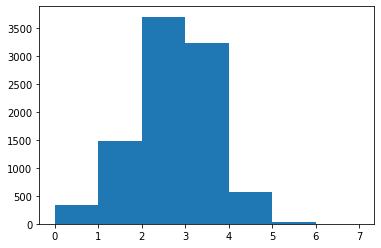

Average number of words is 2.2483429548856106
Max number of words is 6


In [40]:
totalNumWords = [len(one_comment) for one_comment in prod_tokenized_test]
plt.hist(totalNumWords,bins = np.arange(0,8,1))
plt.show()
print("Average number of words is",np.average(totalNumWords))
print("Max number of words is",np.max(totalNumWords))

In [41]:
X_prod = pad_sequences(prod_tokenized_test, maxlen=maxlen)

In [42]:
pred_product=model.predict(X_prod)
pred_product=pd.DataFrame(pred_product,columns=ylist,index=prod.index)

In [43]:
result=prod

In [44]:
result[ylist]=pred_product

In [45]:
result['Pred_Family']=pred_product[ylist].idxmax(axis=1)

In [46]:
col = result['Pred_Family'] # df.pop('F') # if you want it removed
result.insert(result.columns.get_loc('Title') + 1, col.name, col, allow_duplicates=True)
result = result.iloc[:,:-1]

In [47]:
result.to_excel('production_result.xlsx', index=False)

In [48]:
result

,Company ID,Company,Title,Pred_Family,General Management,Finance,Human Resources,Communications & Corporate Affairs,"Legal, Compliance & Audit","Administration, Facilities & Secretarial",...,Production & Skilled Trades,"IT, Telecom & Internet","Data Analytics/Warehousing, & Business Intelligence",Consumer & Commercial Banking,Insurance,Hospitality (Food Service & Lodging),Creative & Design,"Real Estate Management, Property Development & Investment",Construction,Healthcare/Pharmacy Services
0,103,Listia Inc.,ceo,"Sales, Marketing & Product Management",1.245434e-03,5.059211e-03,1.196873e-01,6.408858e-04,1.320150e-02,7.762451e-04,...,2.281527e-03,0.003175,8.570882e-04,2.993829e-05,8.188180e-03,4.744653e-02,3.940185e-04,5.762491e-03,1.325992e-06,8.047567e-02
1,103,Listia Inc.,president,"Legal, Compliance & Audit",2.750826e-02,3.229887e-02,3.262660e-02,2.883775e-02,9.949441e-02,4.405138e-02,...,6.164322e-02,0.039433,2.512545e-02,1.046860e-02,1.921183e-02,6.108247e-02,3.033689e-02,5.265952e-02,9.307776e-03,2.997791e-02
2,103,Listia Inc.,sr software engineer,"IT, Telecom & Internet",3.099169e-07,3.381135e-10,1.422667e-07,1.901815e-09,1.545233e-09,1.541675e-08,...,1.799779e-08,0.999995,5.649049e-07,1.283265e-15,1.607567e-13,3.459682e-09,8.730998e-07,6.068171e-08,3.621760e-10,1.520312e-11
3,103,Listia Inc.,customer support representative,Customer Service & Contact Center Operations,1.353459e-08,2.782436e-07,3.117675e-06,2.514213e-07,4.331062e-11,3.669609e-07,...,2.143078e-08,0.000421,1.559944e-07,2.332984e-09,2.711663e-08,1.195078e-07,3.766155e-09,1.695311e-11,5.495512e-11,8.547966e-10
4,103,Listia Inc.,customer support rep non ca,Customer Service & Contact Center Operations,6.322258e-08,4.247669e-06,7.784402e-05,1.618300e-06,1.364974e-10,1.302724e-06,...,3.590440e-08,0.002721,1.299747e-06,4.742056e-09,1.326865e-07,3.210065e-07,8.809656e-08,7.289035e-10,1.151315e-10,1.249203e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,584,"DFINITY USA Research, LLC",vp of human resources,Human Resources,9.326362e-05,1.265264e-05,9.925827e-01,1.432578e-06,1.903646e-05,5.393645e-07,...,5.775529e-06,0.003855,1.015323e-06,1.681039e-12,3.496197e-08,1.060646e-04,1.028798e-05,6.323992e-05,2.832519e-10,4.451272e-06
9352,585,Arch Asset Management LLC,regional manager,Supply Chain,1.744600e-02,1.824794e-04,1.921341e-03,1.844779e-03,9.025521e-03,5.153240e-04,...,6.123206e-03,0.086055,3.040647e-04,5.770664e-05,1.513525e-04,5.854051e-03,1.345432e-03,1.317401e-04,1.617202e-05,2.727918e-05
9353,585,Arch Asset Management LLC,property accountant,"Real Estate Management, Property Development &...",3.611137e-07,1.060730e-01,5.587425e-05,3.639082e-04,3.997077e-02,4.343566e-03,...,7.704057e-04,0.000002,1.080455e-05,1.802690e-06,4.145484e-05,1.844880e-04,5.068160e-04,8.260602e-01,5.099357e-07,7.680967e-05
9354,586,Vetted PetCare Inc,admin,"Legal, Compliance & Audit",2.750826e-02,3.229887e-02,3.262660e-02,2.883775e-02,9.949441e-02,4.405138e-02,...,6.164322e-02,0.039433,2.512545e-02,1.046860e-02,1.921183e-02,6.108247e-02,3.033689e-02,5.265952e-02,9.307776e-03,2.997791e-02
